In [2]:
import config
import copy
import helper_fxns as hf
import transforms as tr
import importlib
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from scipy.ndimage.filters import gaussian_filter
import time
%matplotlib inline

In [3]:
importlib.reload(hf)
importlib.reload(tr)
importlib.reload(config)
C = config.Config()

In [280]:
n=1500

In [272]:
gen_imgs("cyst", C.dims, n)

In [281]:
#gen_imgs("hcc", C.dims, n)
#gen_imgs("hemangioma", C.dims, n)
#gen_imgs("cholangio", C.dims, n)
gen_imgs("colorectal", C.dims, n)
gen_imgs("fnh", C.dims, n)

img2 = blur_2d(img, 1.6)
hf.plot_section_auto_scan(img2, 0.3)

img = gen_hccs(C.dims, 30)[10]
hf.plot_section_auto_scan(img, 0.3)

In [ ]:
# hemangiomas add nodular enhancement, including in arterial; may fill in completely
# cholangios add variation in amount of enhancement over time
# add rotation
# check distortions along other axes
# try shifting phases out of plane
# look at colorectal cases and try to match
# add fnh

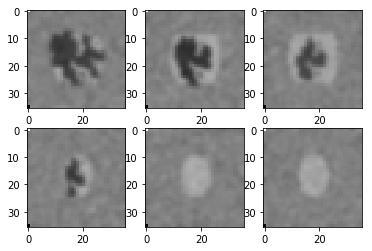

In [41]:
cls = "cholangio"
img = np.load(C.artif_dir + cls + "\\artificial_120.npy")
hf.plot_section_auto_scan(img, 0.3)

In [23]:
def gen_imgs(cls, final_size, n=500):
    if cls == "cyst":
        imgs = gen_cysts(final_size, n)
    elif cls == "hcc":
        imgs = gen_hccs(final_size, n)
    elif cls == "hemangioma":
        imgs = gen_hemangiomas(final_size, n)
    elif cls == "cholangio":
        imgs = gen_cholangios(final_size, n)
    elif cls == "colorectal":
        imgs = gen_colorectals(final_size, n)
    elif cls == "fnh":
        imgs = gen_fnhs(final_size, n)
    
    if not os.path.exists(C.artif_dir + cls):
        os.makedirs(C.artif_dir + cls)
    for cnt, img in enumerate(imgs):
        np.save(C.artif_dir + cls + "\\artificial_" + str(cnt), blur_2d(img, random.uniform(.7, 2.3)))

In [129]:
def blur_2d(orig_img, sigma):
    img = copy.deepcopy(orig_img)
    for ch in range(img.shape[3]):
        for sl in range(img.shape[2]):
            img[:,:,sl,ch] = gaussian_filter(img[:,:,sl,ch], sigma)
        
    return img

In [5]:
def add_edge(img, edge_frac=0.2):
    final_size = img.shape
    edge_slope = random.uniform(-.2, .2)
    
    edge_choice = random.randint(1, 4)
    if edge_choice == 1: #vertical
        edge_start = random.uniform(0, final_size[0]*edge_frac)
        for y in range(final_size[1]):
            img[:max(math.floor(edge_start + edge_slope*y),0), y, :, :] = -1

    elif edge_choice == 2:
        edge_start = random.uniform(final_size[0]*(1-edge_frac), final_size[0])
        for y in range(final_size[1]):
            img[math.ceil(edge_start + edge_slope*y):, y, :, :] = -1

    elif edge_choice == 3: #horizontal
        edge_start = random.uniform(0, final_size[1]*edge_frac)
        for x in range(final_size[0]):
            img[x, :max(math.floor(edge_start + edge_slope*x),0), :, :] = -1

    else:
        edge_start = random.uniform(final_size[1]*(1-edge_frac), final_size[1])
        for x in range(final_size[0]):
            img[x, math.ceil(edge_start + edge_slope*x):, :, :] = -1
    
    return img

# Artificial Cysts

In [150]:
def gen_cysts(final_size, n):
    """Generate n images of cysts with dimensions of final_size plus channels defined by the config file.
    Should be round and hypointense in all phases."""
    
    shades = [-0.8, -0.8, -0.8]
    return gen_round_lesions(shades, final_size, n=n)

In [233]:
def gen_round_lesions(shades, final_size, shade_offset=0, n=500):
    imgs = []
    long_size_frac = [0.7, 0.9]
    max_side_ratio = 1.5
    noise_std = 0.08
    shade_std = 0.05
    
    side_rat = np.linspace(1/max_side_ratio, max_side_ratio, 8)
    side_rat = list(sum(zip(reversed(side_rat), side_rat), ())[:len(side_rat)]) * math.ceil(n/8)
    sizes = np.linspace(long_size_frac[0]/max_side_ratio, long_size_frac[1]/max_side_ratio, num=n)
    
    midx = final_size[0]//2
    midy = final_size[1]//2
    midz = final_size[2]//2
    z_ratio = midy/midz
    
    for i in range(n):
        r = midx * sizes[i]
        shade_offset_i = random.uniform(-shade_offset, shade_offset)
        shades_i = [shade+random.gauss(0, shade_std)+shade_offset_i for shade in shades]
        
        img = np.random.normal(scale = noise_std, size = final_size + [C.nb_channels])
        for x in range(-math.floor(r), math.floor(r)):
            for y in range(-math.floor(r), math.floor(r)):
                z = (r**2 - x**2 - (y/side_rat[i])**2)
                if z <= 0:
                    continue
                    
                z = int(round(z**(.5)/z_ratio))
                
                if z > midz:
                    z = midz
                    
                img[x+midx, y+midy, midz-z:midy+z, :] = shades_i
        
        img += np.random.normal(scale = noise_std, size = final_size + [C.nb_channels])
        img = add_edge(img)
        
        imgs.append(img)
        
    return imgs

In [234]:
def gen_shrinking_lesions(shades, final_size, n=500):
    """Generate n images of hemangiomas with dimensions of final_size plus channels defined by the config file.
    Should be hypointense in all phases, but shrink over time."""
    
    imgs = []
    long_size_frac = [0.7, 0.9]
    max_side_ratio = 1.5
    noise_std = 0.08
    shade_std = 0.05
    
    side_rat = np.linspace(1/max_side_ratio, max_side_ratio, 8)
    side_rat = list(sum(zip(reversed(side_rat), side_rat), ())[:len(side_rat)]) * math.ceil(n/8)
    sizes = np.linspace(long_size_frac[0]/max_side_ratio, long_size_frac[1]/max_side_ratio, num=n)
    
    midx = final_size[0]//2
    midy = final_size[1]//2
    midz = final_size[2]//2
    z_ratio = midy/midz
    shrink_factor = [0.5, 0.8]
    
    for i in range(n):
        r = midx * sizes[i]
        rven = r * random.uniform(shrink_factor[0], shrink_factor[1])
        req = rven * random.uniform(shrink_factor[0], shrink_factor[1])
        shades_i = [shade+random.gauss(0, shade_std) for shade in shades]
        
        img = np.random.normal(scale = noise_std, size = final_size + [C.nb_channels])
        for x in range(-math.floor(r), math.floor(r)):
            for y in range(-math.floor(r), math.floor(r)):
                for ch, rad in enumerate([r, rven, req]):
                    z = (rad**2 - x**2 - (y/side_rat[i])**2)
                    if z <= 0:
                        continue

                    z = int(round(z**(.5)/z_ratio))

                    if z > midz:
                        z = midz

                    img[x+midx, y+midy, midz-z:midy+z, ch] = shades_i[ch]
        
        img += np.random.normal(scale = noise_std, size = final_size + [C.nb_channels])
        img = add_edge(img)
                
        imgs.append(img)
        
    return imgs

In [235]:
def gen_rimmed_lesions(shades, final_size, rim_shades=[.3, .3, .3], rim_ratio = 0.9, shrink_factor = [1,1], n=500):
    """Generate n images of hemangiomas with dimensions of final_size plus channels defined by the config file.
    Should be hypointense in all phases, but shrink over time."""
    
    imgs = []
    long_size_frac = [0.75, 0.95]
    max_side_ratio = 1.5
    noise_std = 0.08
    shade_std = 0.05
    
    side_rat = np.linspace(1/max_side_ratio, max_side_ratio, 8)
    side_rat = list(sum(zip(reversed(side_rat), side_rat), ())[:len(side_rat)]) * math.ceil(n/8)
    sizes = np.linspace(long_size_frac[0]/max_side_ratio, long_size_frac[1]/max_side_ratio, num=n)
    
    midx = final_size[0]//2
    midy = final_size[1]//2
    midz = final_size[2]//2
    z_ratio = midy/midz
    
    for i in range(n):
        r = midx * sizes[i]
        r_core = r * rim_ratio
        rven = r_core * random.uniform(shrink_factor[0], shrink_factor[1])
        req = rven * random.uniform(shrink_factor[0], shrink_factor[1])
        
        shades_i = [shade+random.gauss(0, shade_std) for shade in shades]
        
        img = np.random.normal(scale = noise_std, size = final_size + [C.nb_channels])
        for x in range(-math.floor(r), math.floor(r)):
            for y in range(-math.floor(r), math.floor(r)):
                z = (r**2 - x**2 - (y/side_rat[i])**2)
                if z <= 0:
                    continue
                    
                z = int(round(z**(.5)/z_ratio))
                
                if z > midz:
                    z = midz
                    
                img[x+midx, y+midy, midz-z:midy+z, :] = rim_shades
                
                for ch, rad in enumerate([r_core, rven, req]):
                    z = (rad**2 - x**2 - (y/side_rat[i])**2)
                    if z <= 0:
                        continue

                    z = int(round(z**(.5)/z_ratio))

                    if z > midz:
                        z = midz

                    img[x+midx, y+midy, midz-z:midy+z, ch] = shades_i[ch]
        
        img += np.random.normal(scale = noise_std, size = final_size + [C.nb_channels])
        img = add_edge(img)
                
        imgs.append(img)
        
    return imgs

In [236]:
def gen_heterogen_lesions(shades, final_size, rim_shades=[.3, .3, .3], rim_ratio = 0.9, shrink_factor = [1,1], n=500):
    """Generate n images of hemangiomas with dimensions of final_size plus channels defined by the config file.
    Should be hypointense in all phases, but shrink over time."""
    
    imgs = []
    long_size_frac = [0.75, 0.95]
    max_side_ratio = 1.5
    noise_std = 0.08
    shade_std = 0.05
    
    side_rat = np.linspace(1/max_side_ratio, max_side_ratio, 8)
    side_rat = list(sum(zip(reversed(side_rat), side_rat), ())[:len(side_rat)]) * math.ceil(n/8)
    sizes = np.linspace(long_size_frac[0]/max_side_ratio, long_size_frac[1]/max_side_ratio, num=n)
    
    midx = final_size[0]//2
    midy = final_size[1]//2
    midz = final_size[2]//2
    z_ratio = midy/midz
    spread = 2
    
    for i in range(n):
        r = midx * sizes[i]
        r_core = r * rim_ratio
        rven = r_core * random.uniform(shrink_factor[0], shrink_factor[1])
        req = rven * random.uniform(shrink_factor[0], shrink_factor[1])
        
        shades_i = [shade+random.gauss(0, shade_std) for shade in shades]
        rim_shades_i = [rim_shade+random.gauss(0, shade_std) for rim_shade in rim_shades]
        
        img = np.random.normal(scale = noise_std, size = final_size + [C.nb_channels])
        for x in range(-math.floor(r), math.floor(r)):
            for y in range(-math.floor(r), math.floor(r)):
                z = (r**2 - x**2 - (y/side_rat[i])**2)
                if z <= 0:
                    continue
                    
                z = int(round(z**(.5)/z_ratio))
                
                if z > midz:
                    z = midz
                    
                img[x+midx, y+midy, midz-z:midy+z, :] = rim_shades
                
                if random.random() < 0.8:
                    z = (r_core**2 - x**2 - (y/side_rat[i])**2)
                    if z <= 0:
                        continue
                    z = int(round(z**(.5)/z_ratio))
                    if z > midz:
                        z = midz
                        
                    img[x+midx, y+midy, midz-z:midy+z, :] = rim_shades_i
                    
                elif random.random() < 0.5:
                    for ch, rad in enumerate([r_core, rven, req]):
                        z = (rad**2 - x**2 - (y/side_rat[i])**2)
                        if z <= 0:
                            continue
                        z = int(round(z**(.5)/z_ratio))
                        if z > midz:
                            z = midz
                            
                        img[x+midx-spread:x+midx+spread, y+midy-spread:y+midy+spread, midz-z:midy+z, ch] = shades_i[ch]
                        
                else:
                    for ch, rad in enumerate([r_core, rven, req]):
                        z = (rad**2 - x**2 - (y/side_rat[i])**2)
                        if z <= 0:
                            continue
                        z = int(round(z**(.5)/z_ratio))
                        if z > midz:
                            z = midz
                            
                        img[x+midx, y+midy, midz-z:midy+z, ch] = shades_i[ch]
        
        img += np.random.normal(scale = noise_std, size = final_size + [C.nb_channels])
        img = add_edge(img)
                
        imgs.append(img)
        
    return imgs

In [237]:
def gen_hccs(final_size, n):
    """Generate n images of hccs with dimensions of final_size plus channels defined by the config file.
    Should be round, enhancing in arterial, with washout in venous and delayed."""
    
    shades = [0.2, -0.2, -0.15]
    shade_offset = 0.1
    return gen_round_lesions(shades, final_size, shade_offset=shade_offset, n=n)

In [278]:
def gen_hemangiomas(final_size, n):
    """Generate n images of hccs with dimensions of final_size plus channels defined by the config file.
    Should be round, enhancing in arterial, with washout in venous and delayed."""
    
    shades = [-0.8, -0.8, -0.8]
    return gen_rimmed_lesions(shades, final_size, rim_shades=[0.1, 0.15, 0.15], shrink_factor=[0.5, 0.8], rim_ratio=1.01, n=n)

In [239]:
def gen_cholangios(final_size, n):
    """Generate n images of cysts with dimensions of final_size plus channels defined by the config file.
    Mass-forming should have irregular, ragged rim enhancement with gradual centripetal enhancement."""
    
    shades = [-0.6, -0.5, -0.4]
    return gen_heterogen_lesions(shades, final_size, shrink_factor=[.7, .9], rim_ratio=0.92, n=n)

In [279]:
def gen_colorectals(final_size, n):
    """Generate n images of cysts with dimensions of final_size plus channels defined by the config file.
    Should be hypointense in all phases (necrotic core) with an enhancing rim. Sometimes enhances or shrinks over time(?)"""
    
    shades = [-0.5, -0.5, -0.45]
    return gen_rimmed_lesions(shades, final_size, rim_shades=[.5,.35,.35], shrink_factor=[.85, .95], rim_ratio=0.86, n=n)

# Artificial FNH

In [ ]:
def gen_fnhs(shades, final_size, n):
    """Generate n images of cysts with dimensions of final_size plus channels defined by the config file.
    Should be hypointense in all phases (necrotic core) with an enhancing rim."""
    
    shades = [-0.5, -0.5, -0.5]
    return gen_rimmed_lesions(shades, final_size, n)